In [1]:
import torch
import numpy as np
from torch import nn,optim
from torch.utils.data import Dataset, DataLoader
import pyreadr
import torch.nn.functional as F
import matplotlib.pyplot as plt 
from torch.autograd import Variable

In [2]:
# check pytorch version
print(torch.__version__)

1.4.0


In [3]:
# Define the class to get our dataset.
class Data(Dataset):
    def __init__(self, TrainSet_eonr2_df):
        self.x=torch.FloatTensor(TrainSet_eonr2_df[pred_vars].values)
        self.y=torch.FloatTensor(TrainSet_eonr2_df['eonr'].values)
        self.y=self.y.view(-1,1)
        self.len=self.x.shape[0]
    def __getitem__(self,index):         
        return self.x[index],self.y[index]
    def __len__(self):
        return self.len

In [4]:
# Get our training dataset.
pred_vars = pyreadr.read_r("/home/germanm2/n_policy_box/Data/files_rds/pred_vars.rds")[None] # also works for RData
pred_vars = [item for sublist in pred_vars.values.tolist()  for item in sublist]

TrainSet_eonr2_df = pyreadr.read_r("/home/germanm2/n_policy_box/Data/files_rds/TrainSet_eonr2.rds")[None] # also works for RData
data_set=Data(TrainSet_eonr2_df)

In [5]:
# Get our validation dataset.
prediction_set_aggregated_df = pyreadr.read_r("/home/germanm2/n_policy_box/Data/files_rds/prediction_set_aggregated_dt.rds")[None] # also works for RData
prediction_set_aggregated_df = prediction_set_aggregated_df.rename(columns={"eonr_12": "eonr"})
validation_set = Data(prediction_set_aggregated_df)

In [ ]:
# Create the class for model 
class Net(torch.nn.Module):
    def __init__(self, cols):
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Linear(cols, 21)   # hidden layer
        self.hidden2 = torch.nn.Linear(21, 10)   # hidden layer
        self.predict = torch.nn.Linear(10, 1)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden1(x))      # activation function for hidden layer
        x = F.relu(self.hidden2(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x
    
cols = len(pred_vars)
model = Net(cols)

In [6]:
# Create the class for model (with Dropout)

class Net(nn.Module):
    
    # Constructor
    def __init__(self, cols, p=0):
        super(Net, self).__init__()
        self.drop = nn.Dropout(p=p)
        self.hidden1 = torch.nn.Linear(cols, 10)   # hidden layer
        self.hidden2 = torch.nn.Linear(10, 10)   # hidden layer
        self.predict = torch.nn.Linear(10, 1)   # output layer
        
    def forward(self, x):
        x = F.relu(self.drop(self.hidden1(x)))
        x = F.relu(self.drop(self.hidden2(x)))
        x = self.predict(x)
        return x
cols = len(pred_vars)
model = Net(cols, p=0.2)
# Set the model to training mode

model.train()

Net(
  (drop): Dropout(p=0.2, inplace=False)
  (hidden1): Linear(in_features=21, out_features=10, bias=True)
  (hidden2): Linear(in_features=10, out_features=10, bias=True)
  (predict): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Create the class for model (simple)
class Net(torch.nn.Module):
    def __init__(self, cols):
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Linear(cols, 1)   # hidden layer
        self.predict = torch.nn.Linear(1, 1)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden1(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x
    
cols = len(pred_vars)
model = Net(cols)

In [ ]:
# Make one prediction
x = data_set[0][0]
y = data_set[0][0]
print(model.state_dict())
print(model(x))


In [7]:
#  Create the function to train our model, which accumulate lost for each iteration to obtain the cost.
def train_mini_batches(data_set, train_loader, validation_set, model,criterion, optimizer, epochs=5):
    cost_training=[] 
    cost_validation=[]
    for epoch in range(epochs):
        total = 0

        for x,y in train_loader:
            optimizer.zero_grad()
            
            yhat=model(x)
            loss=criterion(yhat,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total+=loss.item()
        cost_training.append(criterion(model(data_set.x),data_set.y))
        cost_validation.append(criterion(model(validation_set.x),validation_set.y))
    plt.figure()
    plt.plot(cost_training, label='training') 
    plt.plot(cost_validation, label='validation') 
    plt.xlabel('epoch')
    plt.ylabel('cost')
    plt.legend()
    plt.show()

In [ ]:
def train(data_set, validation_set, model,criterion, optimizer, epochs=5):
    cost_training=[] 
    cost_validation=[]  
    for epoch in range(epochs):
         #all the samples are used for training because they fit in memory
        optimizer.zero_grad()
        yhat = model(data_set.x)
        loss=criterion(yhat,data_set.y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cost_training.append(loss)
        cost_validation.append(criterion(model(validation_set.x),validation_set.y))
    plt.figure()
    plt.plot(cost_training, label='training') 
    plt.plot(cost_validation, label='validation') 
    plt.xlabel('epoch')
    plt.ylabel('cost')
    plt.legend()
    plt.show()

In [ ]:
# # Get a single item from enumerate

# singleitem = next(iter(train_loader))
# x = singleitem[0]
# y = singleitem[1]
# yhat = model(x)

In [ ]:
# print(yhat,y)
# criterion(yhat,y)

/opt/anaconda3/envs/GEOANN/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


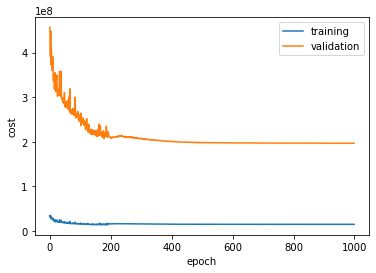

In [8]:
# Create our model 

torch.manual_seed(0)
learning_rate = 0.01
criterion = torch.nn.MSELoss(size_average=False)  # this is for regression mean squared loss
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loader=DataLoader(dataset=data_set,batch_size=32)
train_mini_batches(data_set, train_loader, validation_set, model,criterion, optimizer, epochs=1000)
# train(data_set, validation_set, model,criterion, optimizer, epochs=1000)

In [ ]:
# Make one prediction after training
model.eval()
x = data_set[0][0]
y = data_set[0][1]
model.state_dict()
print(y, model(x))

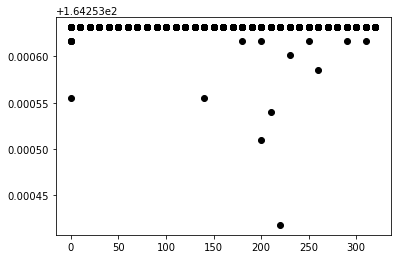

In [9]:
#Make predictions with returned model
prediction_set_aggregated_df = pyreadr.read_r("/home/germanm2/n_policy_box/Data/files_rds/prediction_set_aggregated_dt.rds")[None] # also works for RData

X = Variable(torch.FloatTensor(prediction_set_aggregated_df[pred_vars].values)) 
model.eval()
y_pred = model(X) #This outputs the value for regression
y_pred=y_pred.data[:,0].numpy()

prediction_set_aggregated_df['eonr_pred'] = y_pred

plt.plot(prediction_set_aggregated_df['eonr_12'], prediction_set_aggregated_df['eonr_pred'], 'o', color='black')


In [10]:
from sklearn.metrics import mean_squared_error

print(prediction_set_aggregated_df['eonr_pred'].min(),
prediction_set_aggregated_df['eonr_pred'].max(),
prediction_set_aggregated_df['eonr_pred'].mean(),
mean_squared_error(prediction_set_aggregated_df['eonr_12'], prediction_set_aggregated_df['eonr_pred']))

164.25341796875 164.25363159179688 164.31637573242188 3250.0823174359643


In [ ]:
4050 3593 (21, 21, 10, 1) 3130 3250

In [ ]:
def build_cnn(TrainSet_eonr2_df, policy, pred_vars):
    #Define training hyperprameters.
    batch_size = 50
    num_epochs = 100
    learning_rate = 0.01
    size_hidden= 100
    
    y_train = TrainSet_eonr2_df['eonr']
    #X_train = TrainSet_eonr2_df.drop('eonr', axis=1)
    X_train = TrainSet_eonr2_df[pred_vars]
    
    X_train=X_train.values
    y_train=y_train.values

    #Calculate some other hyperparameters based on data.  
    batch_no = len(X_train) // batch_size  #batches
    cols=X_train.shape[1] #Number of columns in input matrix
    n_output=1

    #Create the model
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # Assume that we are on a CUDA machine, then this should print a CUDA device:
    print("Executing the model on :",device)

    net = Net(cols, size_hidden, n_output)

    #Adam is a specific flavor of gradient decent which is typically better
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    #optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
    criterion = torch.nn.MSELoss(size_average=False)  # this is for regression mean squared loss

    running_loss = 0.0
    for epoch in range(num_epochs):
        #Shuffle just mixes up the dataset between epocs
        X_train, y_train = shuffle(X_train, y_train)
        # Mini batch learning
        for i in range(batch_no):
            start = i * batch_size
            end = start + batch_size
            inputs = Variable(torch.FloatTensor(X_train[start:end]))
            labels = Variable(torch.FloatTensor(y_train[start:end]))
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            #print("outputs",outputs)
            #print("outputs",outputs,outputs.shape,"labels",labels, labels.shape)
            loss = criterion(outputs, torch.unsqueeze(labels,dim=1))
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        #print('Epoch {}'.format(epoch+1), "loss: ",running_loss)
        running_loss = 0.0
    path = '/home/germanm2/n_policy_box/Data/files_rds/cnn_models/'+ policy + '.pth'
    torch.save(net.state_dict(), path)
    return(net)  
        

In [ ]:
#Make predictions with returned model
prediction_set_aggregated_df = pyreadr.read_r("/home/germanm2/n_policy_box/Data/files_rds/prediction_set_aggregated_dt.rds")[None] # also works for RData

X = Variable(torch.FloatTensor(prediction_set_aggregated_df[pred_vars].values)) 

y_pred = model(X) #This outputs the value for regression
y_pred=y_pred.data[:,0].numpy()

prediction_set_aggregated_df['eonr_pred'] = y_pred

In [ ]:
#Make predictions with returned model
prediction_set_aggregated_df = pyreadr.read_r("/home/germanm2/n_policy_box/Data/files_rds/prediction_set_aggregated_dt.rds")[None] # also works for RData

X_pred = prediction_set_aggregated_df[pred_vars]

X_pred=X_pred.values

X = Variable(torch.FloatTensor(X_pred)) 
y_pred = net_return(X) #This outputs the value for regression
y_pred=y_pred.data[:,0].numpy()
y_pred
prediction_set_aggregated_df['eonr_pred'] = y_pred

# now let's write a Rds
pyreadr.write_rds("/home/germanm2/n_policy_box/Data/files_rds/prediction_set_aggregated_cnn_dt.rds", prediction_set_aggregated_df)
prediction_set_aggregated_df.head()

In [ ]:
#Load the saved model
policy = 'ratio_5'
path = '/home/germanm2/n_policy_box/Data/files_rds/cnn_models/'+ policy + '.pth'
net_load = Net(21, 100, 1)
net_load.load_state_dict(torch.load(path))
net_load.eval()
net_load.state_dict()


In [ ]:
#Make predictions with the saved model
prediction_set_aggregated_df = pyreadr.read_r("/home/germanm2/n_policy_box/Data/files_rds/prediction_set_aggregated_dt.rds")[None] # also works for RData

X_pred = prediction_set_aggregated_df[pred_vars]
X_pred=X_pred.values
X_pred
X = Variable(torch.FloatTensor(X_pred)) 
y_pred = net_load(X) #This outputs the value for regression
y_pred=y_pred.data[:,0].numpy()
y_pred
prediction_set_aggregated_df['eonr_pred'] = y_pred

# now let's write a Rds
pyreadr.write_rds("/home/germanm2/n_policy_box/Data/files_rds/prediction_set_aggregated_cnn_dt.rds", prediction_set_aggregated_df)
prediction_set_aggregated_df.head()

In [ ]:
# Make a function that loads the saved model and does predictions

prediction_set_aggregated_df = pyreadr.read_r("/home/germanm2/n_policy_box/Data/files_rds/prediction_set_aggregated_dt.rds")[None]
prediction_set_aggregated_df.head()

In [ ]:
def predict_cnn(prediction_set_aggregated_df, policy, pred_vars):
    #Load the saved model
    #policy = 'ratio_5'
    path = '/home/germanm2/n_policy_box/Data/files_rds/cnn_models/'+ policy + '.pth'
    net_load = Net(21, 100, 1)
    net_load.load_state_dict(torch.load(path))
    net_load.eval()
    net_load.state_dict()
    X_pred = prediction_set_aggregated_df[pred_vars]
    X_pred=X_pred.values
    X_pred
    X = Variable(torch.FloatTensor(X_pred)) 
    y_pred = net_load(X) #This outputs the value for regression
    y_pred=y_pred.data[:,0].numpy()
    y_pred
    prediction_set_aggregated_df['eonr_pred'] = y_pred
    return(prediction_set_aggregated_df)

In [ ]:
# Use the function
prediction_set_aggregated_df2 = predict_cnn(prediction_set_aggregated_df, 'ratio_5', pred_vars)
prediction_set_aggregated_df2

In [ ]:
from sklearn.metrics import mean_squared_error

print(prediction_set_aggregated_df['eonr_pred'].min(),
prediction_set_aggregated_df['eonr_pred'].max(),
prediction_set_aggregated_df['eonr_pred'].mean(),
mean_squared_error(prediction_set_aggregated_df['eonr_12'], prediction_set_aggregated_df['eonr_pred']))

In [ ]:
# 3088
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


x = prediction_set_aggregated_df['eonr_12']
y = prediction_set_aggregated_df['eonr_pred']

plt.scatter(x, y, c="g", alpha=0.5, marker=r'$\clubsuit$',
            label="Luck")
plt.legend(loc='upper left')
plt.show()